### Disaster Tweets: Predicting if a tweet is about a real disaster or not

The dataset contains tweets with a label (target) of 0 (not a real disaster) or 1 (real disaster).

This is a binary classification problem, for which I'll be experimenting with LSTM and GRU models to make the predictions.

For this competition, submissions are evaluated using F1 between the predicted and expected answers.

F1 = 2*((precision * recall)/(precision + recall))

precision = true_positives / (true_positives + false_positives)

recall = true_positives / (true_positives + false_negatives)


#### Data Structure
The input training set seems to be composed of 5 columns:
- id: An integer ID for the tweet, not useful for this problem.
- keyword: The keywords that indicate a potential disaster, like ablaze, bombing, drowning, etc. It doesn't seem like it's something I can use (details on this in the EDA section).
- location: This field doesn't seem to be very clean, and it probably doesn't contribute to the predictions in a meaninful way anyways.
- text: The actual tweet
- target: The label indicating if it's about a disaster or not





### Data loading and EDA

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# base_path = "/kaggle/input/nlp-getting-started/"
base_path = "./nlp-getting-started/"

train = pd.read_csv(f"{base_path}train.csv")

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Looks like keyword and location are empty. Let's explore that a bit more.

In [6]:
separator = "\n========================================\n"

unique_keywords = train["keyword"].unique()
print(f"Total unique keywords: {len(unique_keywords)}")
print(unique_keywords)

print(separator)
unique_locations = train["location"].unique()
print(f"Total unique locations: {len(unique_locations)}")
print(unique_locations)

Total unique keywords: 222
[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'd

Those columns are not empty after all, but by looking at this and inspecting the actual data, I think the best option is to just discard them for now. There's rows labeled 1 with no keywords at all and vice-versa.

In respect to location, it seems that it's probably not worth including either

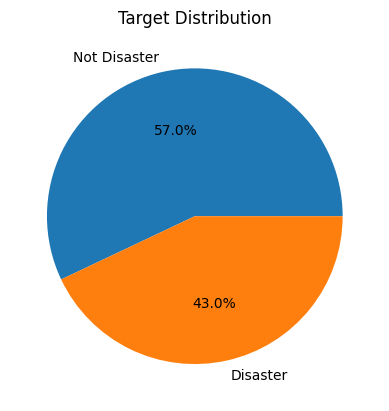

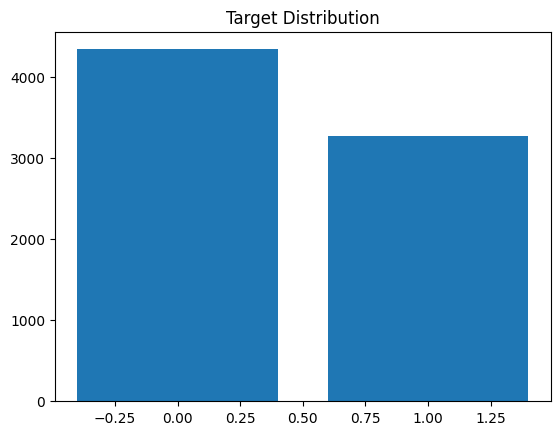

In [7]:
import matplotlib.pyplot as plt
train["target"].value_counts()

# Pie chart of the target distribution
plt.figure()
plt.pie(train["target"].value_counts(), labels=["Not Disaster", "Disaster"], autopct="%1.1f%%")
plt.title("Target Distribution")
plt.show()

# Bar chart of the target distribution
plt.figure()
plt.bar(train["target"].value_counts().index, train["target"].value_counts().values)
plt.title("Target Distribution")
plt.show()

There's a significant class imbalance, I'll probably have to adjust for this when training.

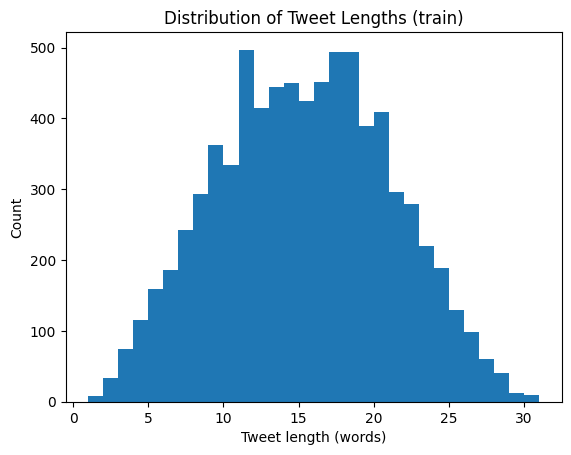

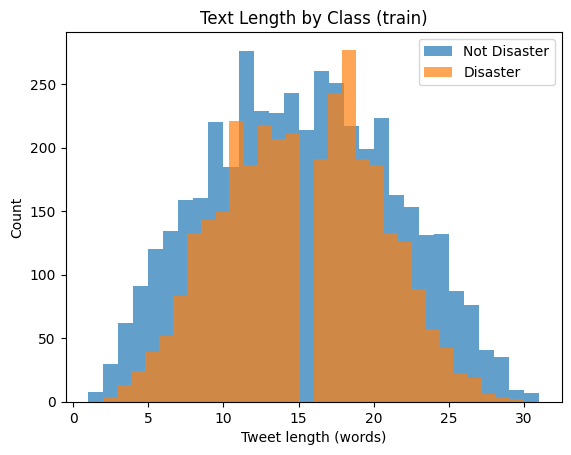

In [8]:
import re
import string


# This is to count words
def text_length(s):
    return len(s.split()) if s else 0

train["text_len"] = train["text"].apply(text_length)

plt.figure()
plt.hist(train["text_len"].dropna(), bins=30)
plt.xlabel("Tweet length (words)")
plt.ylabel("Count")
plt.title("Distribution of Tweet Lengths (train)")
plt.show()


plt.figure()
plt.hist(train.loc[train["target"]==0, "text_len"].dropna(), bins=30, alpha=0.7)
plt.hist(train.loc[train["target"]==1, "text_len"].dropna(), bins=30, alpha=0.7)
plt.xlabel("Tweet length (words)")
plt.ylabel("Count")
plt.legend(["Not Disaster", "Disaster"])
plt.title("Text Length by Class (train)")
plt.show()








#### Character Length

We can inspect if there's a pattern between the length of chars in a tweet vs the label.

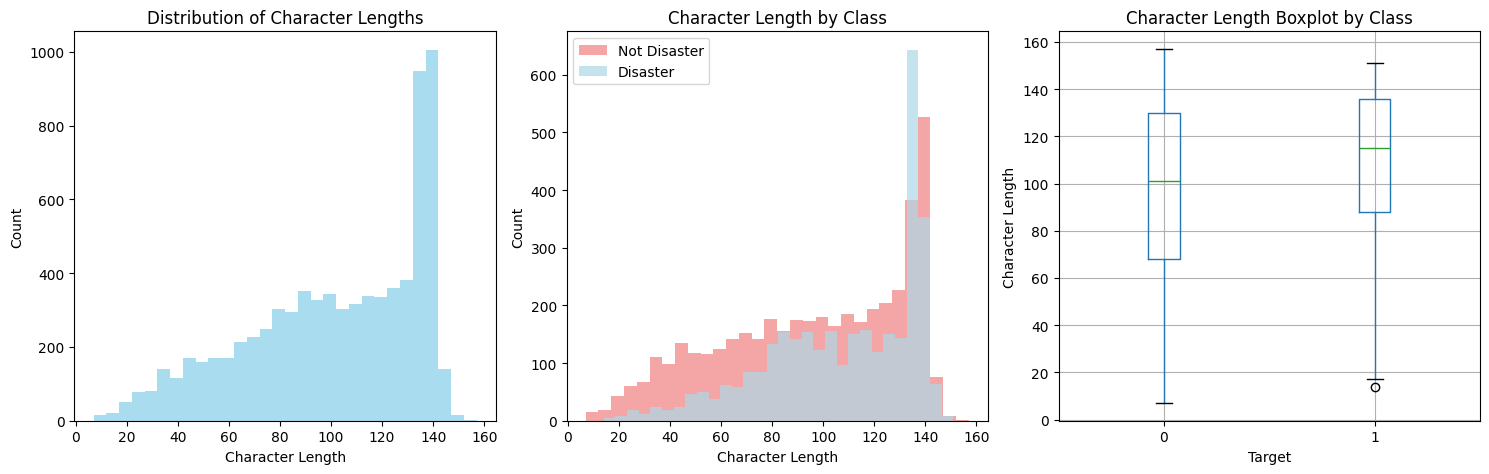

In [ ]:
train["char_len"] = train["text"].str.len()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train["char_len"], bins=30, alpha=0.7, color='skyblue')
plt.xlabel("Character Length")
plt.ylabel("Count")
plt.title("Distribution of Character Lengths")

plt.subplot(1, 3, 2)
plt.hist(train.loc[train["target"]==0, "char_len"], bins=30, alpha=0.7, label="Not Disaster", color='lightcoral')
plt.hist(train.loc[train["target"]==1, "char_len"], bins=30, alpha=0.7, label="Disaster", color='lightblue')
plt.xlabel("Character Length")
plt.ylabel("Count")
plt.legend()
plt.title("Character Length by Class")

plt.subplot(1, 3, 3)
train.boxplot(column="char_len", by="target", ax=plt.gca())
plt.xlabel("Target")
plt.ylabel("Character Length")
plt.title("Character Length Boxplot by Class")
plt.suptitle("")

plt.tight_layout()
plt.show()

The spike we see here is just responding to the old character limit on Twitter, it's not abnormal or anything

#### Word Frequency

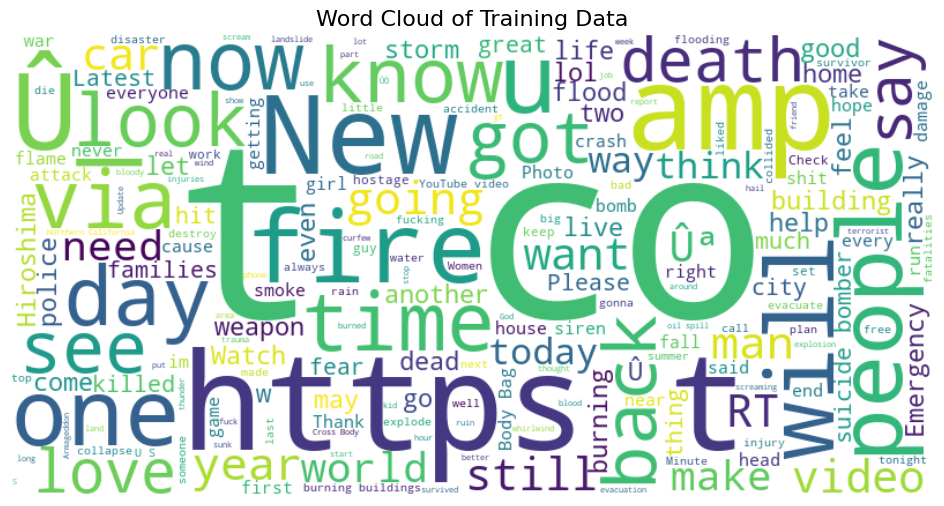

In [9]:
# Word cloud chart

from wordcloud import WordCloud

all_text = " ".join(train["text"])
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=200, colormap="viridis").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Training Data", fontsize=16)
plt.show()

I can see from this word cloud that t.co, https, amp (html ampersand &) and other text that shouldn't be used is very prevalent, this is relatively easy to clean up.

#### Word frequency by class

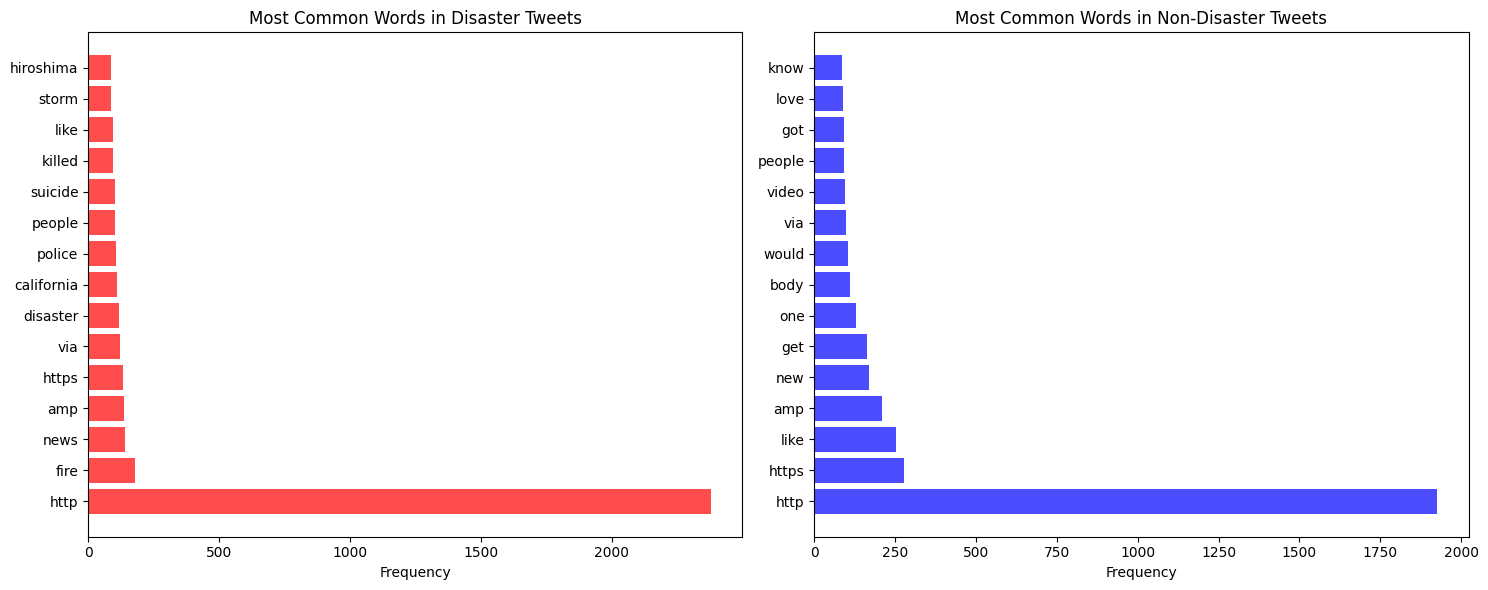

In [10]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Get stopwords
stop_words = set(stopwords.words('english'))

# Function to get word frequencies
def get_word_frequencies(texts, remove_stopwords=True):
    all_words = []
    for text in texts:
        words = word_tokenize(text.lower())
        if remove_stopwords:
            words = [word for word in words if word.isalpha() and word not in stop_words]
        all_words.extend(words)
    return Counter(all_words)

# Get word frequencies for each class
disaster_words = get_word_frequencies(train[train["target"]==1]["text"])
non_disaster_words = get_word_frequencies(train[train["target"]==0]["text"])

# Plot top words for each class
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Disaster tweets
top_disaster = dict(disaster_words.most_common(15))
axes[0].barh(list(top_disaster.keys()), list(top_disaster.values()), color='red', alpha=0.7)
axes[0].set_title("Most Common Words in Disaster Tweets")
axes[0].set_xlabel("Frequency")

# Non-disaster tweets
top_non_disaster = dict(non_disaster_words.most_common(15))
axes[1].barh(list(top_non_disaster.keys()), list(top_non_disaster.values()), color='blue', alpha=0.7)
axes[1].set_title("Most Common Words in Non-Disaster Tweets")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

Just like in the word cloud, the things I need to remove are leading the frequency for both classes.

#### Word length analysis

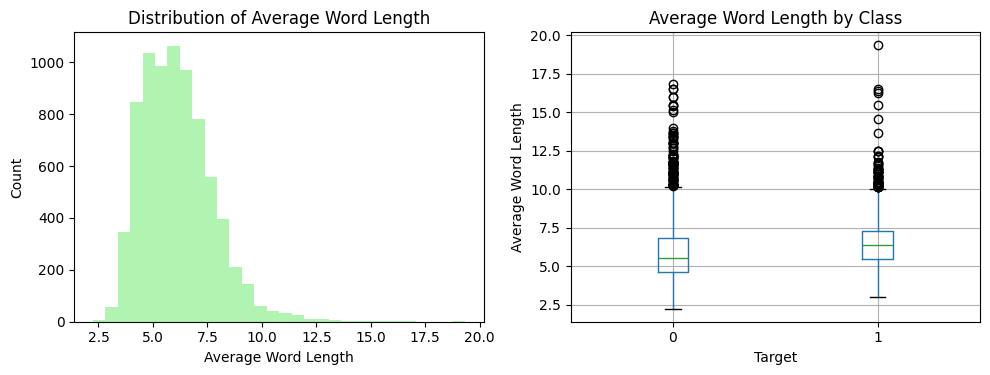

In [11]:
train["avg_word_len"] = train["text"].apply(lambda x: np.mean([len(word) for word in x.split()]) if x else 0)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(train["avg_word_len"], bins=30, alpha=0.7, color='lightgreen')
plt.xlabel("Average Word Length")
plt.ylabel("Count")
plt.title("Distribution of Average Word Length")

plt.subplot(1, 2, 2)
train.boxplot(column="avg_word_len", by="target", ax=plt.gca())
plt.xlabel("Target")
plt.ylabel("Average Word Length")
plt.title("Average Word Length by Class")
plt.suptitle("")

plt.tight_layout()
plt.show()

In terms of word length, there's practically no difference between 0 anf 1 labels. What we see here is probably due to the size of the dataset instead of a real pattern.

#### N-gram Analysis

N-grams are a group of contiguous words in a sentence. In this case I'll focus on Bigrams to see if they might help with context

Sample bigrams that could be useful:
For label 1:
- building collapse
- suicide bombing
- fatal accident
- flight horror

For label 0:
- horror movie
- jaeger bomb
- sunset cruise

Things like 'building collapse' are much more meaningful in context compared to just building and just collapse on their own. I might use this later on if it makes sense

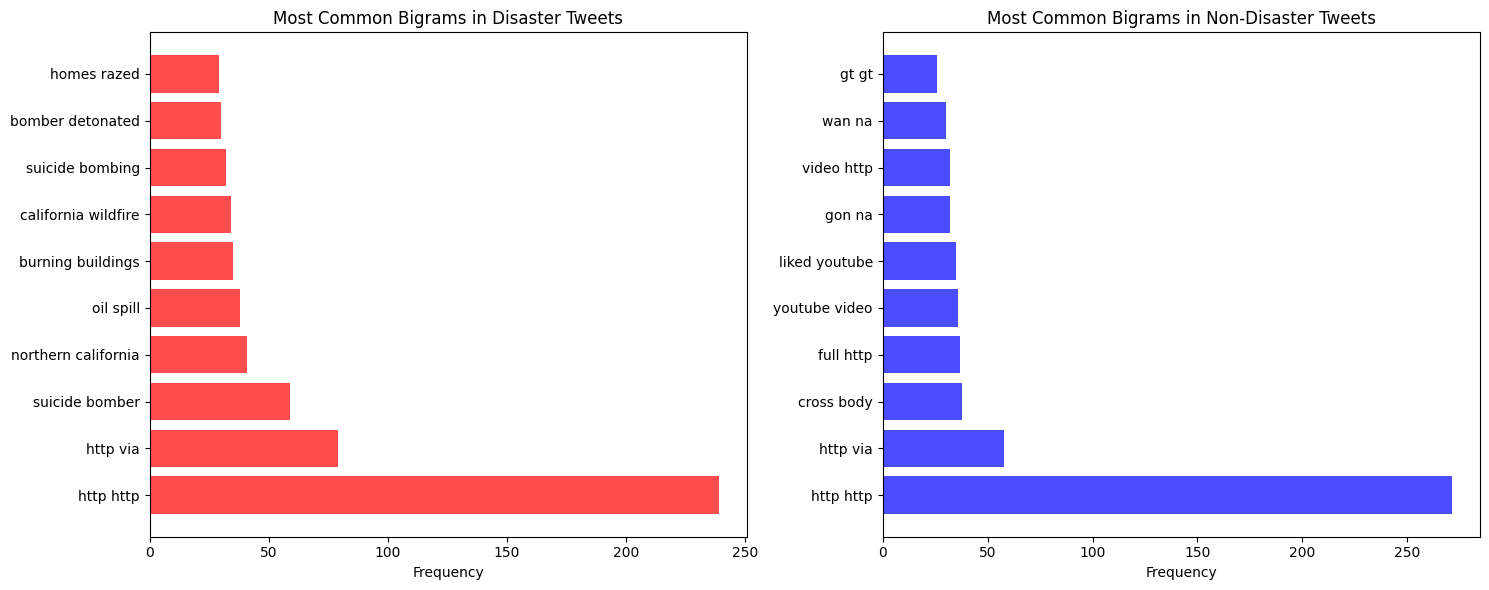

In [12]:
from nltk.util import ngrams

def get_ngrams(texts, n=2, remove_stopwords=True):
    all_ngrams = []
    for text in texts:
        words = word_tokenize(text.lower())
        if remove_stopwords:
            words = [word for word in words if word.isalpha() and word not in stop_words]
        if len(words) >= n:
            ngram_list = list(ngrams(words, n))
            all_ngrams.extend([' '.join(gram) for gram in ngram_list])
    return Counter(all_ngrams)

def plot_bigrams(column):
    # Bigram analysis
    disaster_bigrams = get_ngrams(train[train["target"]==1][column], n=2)
    non_disaster_bigrams = get_ngrams(train[train["target"]==0][column], n=2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Disaster bigrams
    top_disaster_bigrams = dict(disaster_bigrams.most_common(10))
    axes[0].barh(list(top_disaster_bigrams.keys()), list(top_disaster_bigrams.values()), color='red', alpha=0.7)
    axes[0].set_title("Most Common Bigrams in Disaster Tweets")
    axes[0].set_xlabel("Frequency")

    # Non-disaster bigrams
    top_non_disaster_bigrams = dict(non_disaster_bigrams.most_common(10))
    axes[1].barh(list(top_non_disaster_bigrams.keys()), list(top_non_disaster_bigrams.values()), color='blue', alpha=0.7)
    axes[1].set_title("Most Common Bigrams in Non-Disaster Tweets")
    axes[1].set_xlabel("Frequency")

    plt.tight_layout()
    plt.show()

plot_bigrams("text")

It looks like disaster tweets contain disaster specific bigrams, while non disaster tweets just have regular bigrams.

### Cleanup

I'll clean up urls, drop the hashtag symbol but keep the rest, remove mentions, and remove non ASCII characters and a couple of other things that are not useful.



In [13]:
import re
import string

URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
MENTION_PATTERN = re.compile(r"@[A-Za-z0-9_]+")
HASHTAG_PATTERN = re.compile(r"#")
NON_ASCII = re.compile(r"[^\x00-\x7F]+")
HTML_ENTITY_PATTERN = re.compile(r"&[a-zA-Z]+;")  # &amp;, &lt;, &gt;, etc.
T_CO_PATTERN = re.compile(r"t\.co/\w+")  # Twitter's URL shortener
RT_PATTERN = re.compile(r"^RT\s+")  # Remove "RT " at the beginning
VIA_PATTERN = re.compile(r"\s+via\s+")  # Remove "via" mentions
EMOJI_PATTERN = re.compile(r"[^\w\s]")  # Remove emojis and special characters
MULTIPLE_SPACES = re.compile(r"\s+")  # Multiple spaces to single space

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    
    s = s.lower()
    s = URL_PATTERN.sub(" ", s)
    s = T_CO_PATTERN.sub(" ", s)
    s = MENTION_PATTERN.sub(" ", s)
    s = HASHTAG_PATTERN.sub("", s)
    s = HTML_ENTITY_PATTERN.sub(" ", s)
    s = RT_PATTERN.sub("", s)
    s = VIA_PATTERN.sub(" ", s)
    
    s = s.translate(str.maketrans("", "", string.punctuation.replace("'", "").replace(".", "")))
    s = NON_ASCII.sub(" ", s)
    s = EMOJI_PATTERN.sub(" ", s)
    s = MULTIPLE_SPACES.sub(" ", s)
    s = s.strip()
    
    return s

sample_rows = train.sample(5, random_state=42)[["text"]].copy()
sample_rows["clean_text"] = sample_rows["text"].apply(clean_text)
display(sample_rows)

train["clean_text"] = train["text"].apply(clean_text)

print(f"Cleanup removes {train['text'].str.len().sum() - train['clean_text'].str.len().sum()} characters")



,text,clean_text
2644,So you have a new weapon that can cause un-ima...,so you have a new weapon that can cause unimag...
2227,The f$&amp;@ing things I do for #GISHWHES Just...,the f things i do for gishwhes just got soaked...
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,dt rt the col police can catch a pickpocket in...
132,Aftershock back to school kick off was great. ...,aftershock back to school kick off was great i...
6845,in response to trauma Children of Addicts deve...,in response to trauma children of addicts deve...


Cleanup removes 173577 characters


Ok, cleanup done, plotting the bigrams again to see better data.

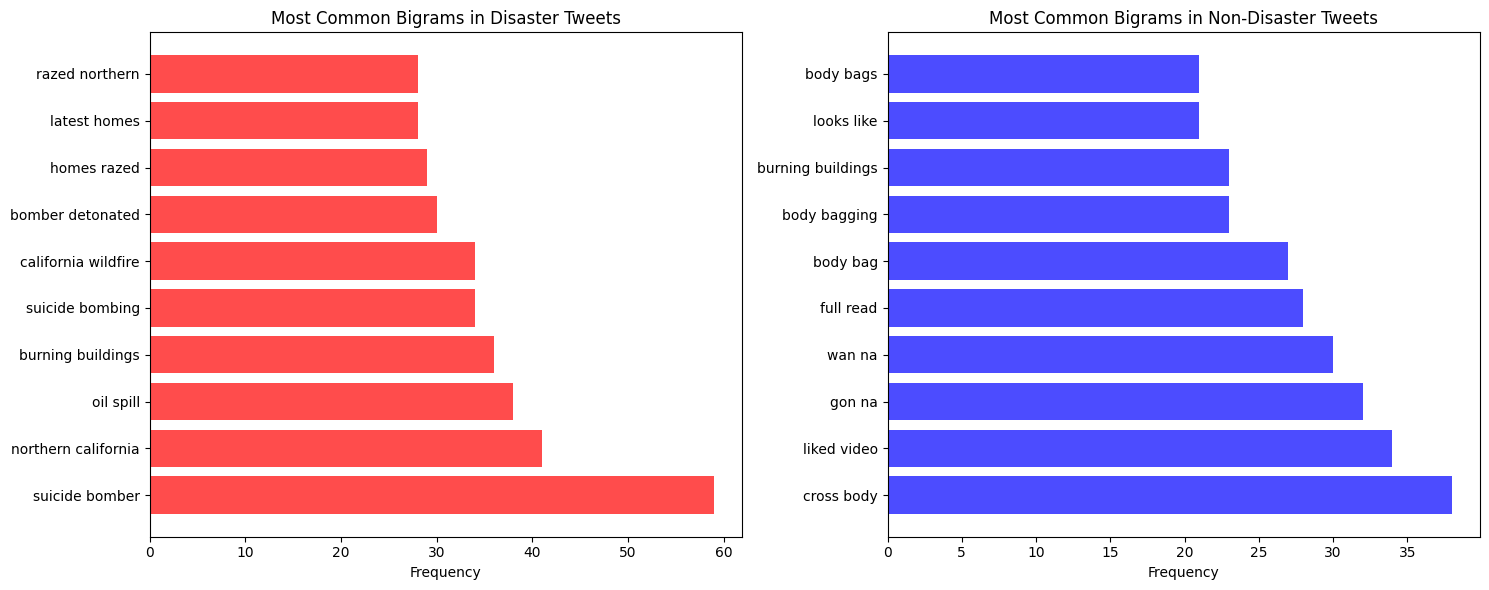

In [14]:
plot_bigrams("clean_text")

### Model Architecture

The EDA showed the following things:
- Significant semantic differences between the classes
- Meaningful bigrams
- Tweets are naturally sequential

Based on this, I'll implement a basic LSTM and a basic GRU. LSTM is supposed to handle sequential data like this very well so it's a decent fit.
GRU should be good at pattern recognition.

#### LSTM
- Embedding layer: To convert tokens to dense vectors (an embedding is the vector space representation of a word or concept).
- LSTM layer: To process the sequences with memory
- Dropout: To prevent overfitting
- Classifier: For the 0 - 1 prediction

#### GRU
- Embedding: Same as LSTM
- GRU layer: Simpler compared to LSTM but should work well nonetheless 
- Dropdout
- Classifier

#### Data preprocessing
- Tokenizaton, using <UNK> for unknown words
- Padding to have consistent length

#### Evaluation
The competition relies on F1 scores, so we'll use that.



In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


class BasicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.3):
        super(BasicLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]
        output = self.dropout(last_hidden)
        output = self.classifier(output)
        return torch.sigmoid(output)

In [16]:
class BasicGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.3):
        super(BasicGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, 
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, hidden = self.gru(embedded)
        last_hidden = hidden[-1]
        output = self.dropout(last_hidden)
        output = self.classifier(output)
        return torch.sigmoid(output)

In [ ]:
def preprocess_data(texts, max_len=100):
    tokenizer = Tokenizer(oov_token="<UNK>")
    tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    return padded_sequences, tokenizer

def get_class_weights(y_train):
    from sklearn.utils.class_weight import compute_class_weight
    
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    return torch.FloatTensor(class_weights)

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    val_f1_scores = []
    best_val_f1 = 0.0
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds = []
        train_true = []
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y.float())
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_preds.extend((outputs > 0.5).long().cpu().numpy())
            train_true.extend(batch_y.cpu().numpy())
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x).squeeze()
                loss = criterion(outputs, batch_y.float())
                val_loss += loss.item()
                
                val_preds.extend((outputs > 0.5).long().cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_f1 = f1_score(train_true, train_preds)
        val_f1 = f1_score(val_true, val_preds)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        print(f'  Positive predictions - Train: {sum(train_preds)}, Val: {sum(val_preds)}')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    return train_losses, val_losses, val_f1_scores

In [19]:
# Data wrapper for pytorch

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.LongTensor(texts)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

Using MPS (Apple Silicon GPU): mps
Preprocessing data...
Class distribution: [4342 3271]
Disaster tweets: 3271 (43.0%)
Vocabulary size: 13386

Training LSTM Model
Epoch 1/30:
  Train Loss: 0.3432, Train F1: 0.0060
  Val Loss: 0.3421, Val F1: 0.0000
  Positive predictions - Train: 32, Val: 0
Epoch 2/30:
  Train Loss: 0.3425, Train F1: 0.0000
  Val Loss: 0.3423, Val F1: 0.0000
  Positive predictions - Train: 0, Val: 0
Epoch 3/30:
  Train Loss: 0.3428, Train F1: 0.0000
  Val Loss: 0.3424, Val F1: 0.0000
  Positive predictions - Train: 0, Val: 0
Epoch 4/30:
  Train Loss: 0.3426, Train F1: 0.0000
  Val Loss: 0.3422, Val F1: 0.0000
  Positive predictions - Train: 0, Val: 0
Epoch 5/30:
  Train Loss: 0.3421, Train F1: 0.0000
  Val Loss: 0.3431, Val F1: 0.0000
  Positive predictions - Train: 0, Val: 0
Early stopping at epoch 5

Training GRU Model
Epoch 1/30:
  Train Loss: 0.3430, Train F1: 0.0000
  Val Loss: 0.3430, Val F1: 0.0000
  Positive predictions - Train: 0, Val: 0
Epoch 2/30:
  Train Lo

/Users/ale/Workspace/Jupyter/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ale/Workspace/Jupyter/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ale/Workspace/Jupyter/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

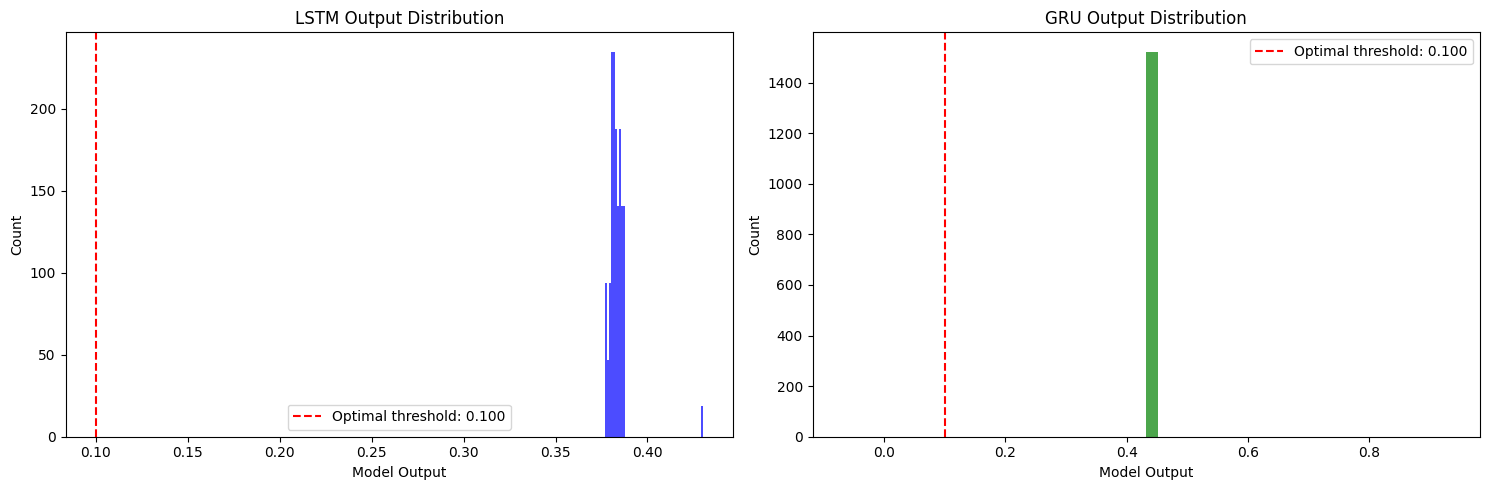

In [ ]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.2
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EPOCHS = 30
MAX_LEN = 100

# This is to optimize for my M4 max macbook pro
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Using MPS (Apple Silicon GPU): {device}')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA GPU: {device}')
else:
    device = torch.device('cpu')
    print(f'Using CPU: {device}')

print("Preprocessing data...")
train_texts = train['clean_text'].values
train_labels = train['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

X_train_padded, tokenizer = preprocess_data(X_train, MAX_LEN)
X_val_padded, _ = preprocess_data(X_val, MAX_LEN)

vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

train_dataset = TweetDataset(X_train_padded, y_train)
val_dataset = TweetDataset(X_val_padded, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

lstm_model = BasicLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)
gru_model = BasicGRU(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=2, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=2, gamma=2)

lstm_optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
gru_optimizer = torch.optim.AdamW(gru_model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)

print(separator)
print("Training LSTM Model")
print(separator)
lstm_train_losses, lstm_val_losses, lstm_val_f1s = train_model(
    lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, EPOCHS
)

print(separator)
print("Training GRU Model")
print(separator)
gru_train_losses, gru_val_losses, gru_val_f1s = train_model(
    gru_model, train_loader, val_loader, criterion, gru_optimizer, device, EPOCHS
)


print(separator)
print("Model Evaluation with Dynamic Threshold")
print(separator)


lstm_model.load_state_dict(torch.load('best_BasicLSTM.pth'))
gru_model.load_state_dict(torch.load('best_BasicGRU.pth'))

lstm_model.eval()
gru_model.eval()

lstm_outputs = []
gru_outputs = []
true_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        lstm_output = lstm_model(batch_x).squeeze()
        gru_output = gru_model(batch_x).squeeze()
        
        lstm_outputs.extend(lstm_output.cpu().numpy())
        gru_outputs.extend(gru_output.cpu().numpy())
        true_labels.extend(batch_y.cpu().numpy())

from sklearn.metrics import f1_score

def find_optimal_threshold(outputs, labels):
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        preds = (np.array(outputs) > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

# Find optimal thresholds
lstm_threshold, lstm_best_f1 = find_optimal_threshold(lstm_outputs, true_labels)
gru_threshold, gru_best_f1 = find_optimal_threshold(gru_outputs, true_labels)

print(f"LSTM optimal threshold: {lstm_threshold:.3f}")
print(f"GRU optimal threshold: {gru_threshold:.3f}")

lstm_preds = (np.array(lstm_outputs) > lstm_threshold).astype(int)
gru_preds = (np.array(gru_outputs) > gru_threshold).astype(int)

print("\nLSTM Results (with optimal threshold):")
print(classification_report(true_labels, lstm_preds))
print(f"LSTM F1 Score: {f1_score(true_labels, lstm_preds):.4f}")
print(f"LSTM Positive Predictions: {sum(lstm_preds)}")
print(f"LSTM Output Range: {min(lstm_outputs):.4f} to {max(lstm_outputs):.4f}")
print(f"LSTM Output Mean: {np.mean(lstm_outputs):.4f}")

print("\nGRU Results (with optimal threshold):")
print(classification_report(true_labels, gru_preds))
print(f"GRU F1 Score: {f1_score(true_labels, gru_preds):.4f}")
print(f"GRU Positive Predictions: {sum(gru_preds)}")
print(f"GRU Output Range: {min(gru_outputs):.4f} to {max(gru_outputs):.4f}")
print(f"GRU Output Mean: {np.mean(gru_outputs):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# LSTM outputs
axes[0].hist(lstm_outputs, bins=50, alpha=0.7, color='blue')
axes[0].axvline(lstm_threshold, color='red', linestyle='--', label=f'Optimal threshold: {lstm_threshold:.3f}')
axes[0].set_title('LSTM Output Distribution')
axes[0].set_xlabel('Model Output')
axes[0].set_ylabel('Count')
axes[0].legend()

# GRU outputs
axes[1].hist(gru_outputs, bins=50, alpha=0.7, color='green')
axes[1].axvline(gru_threshold, color='red', linestyle='--', label=f'Optimal threshold: {gru_threshold:.3f}')
axes[1].set_title('GRU Output Distribution')
axes[1].set_xlabel('Model Output')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

Did a training pass with the following hyperparameters:
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 15
MAX_LEN = 100

LSTM Results:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523

LSTM F1 Score: 0.0000

GRU Results:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523

#### Training summary

Both models seem to perform very poorly. Tweaking hyperparameters doesn't seem to help much. It seems like they both stick around a validation loss of 0.34 and can't move past that.
I've tried dynamic thresholds as well but it didn't help.


#### Ridge Classifier

Next I'll  try the Ridge classifier from the competition tutorial to see if it performs better.

In [32]:
from sklearn import feature_extraction, linear_model, model_selection

train_texts = train["clean_text"]
train_labels = train["target"]

X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(X_train)
val_vectors = count_vectorizer.transform(X_val)

tfidf_transformer = feature_extraction.text.TfidfTransformer()

train_tfidf = tfidf_transformer.fit_transform(train_vectors)

clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(clf, train_vectors, y_train, cv=3, scoring="f1")
scores

clf.fit(train_vectors, y_train)

y_pred = clf.predict(val_vectors)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       869
           1       0.77      0.69      0.73       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



Whoa, what a difference. I think this is it. I'll generate the submission using this model next.

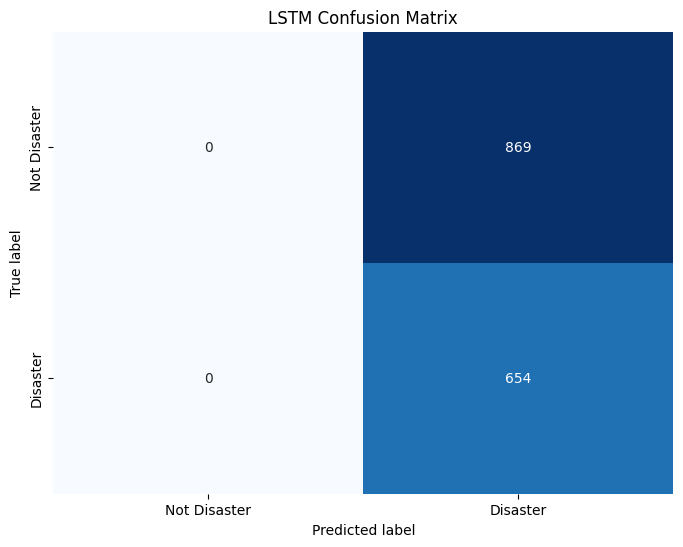

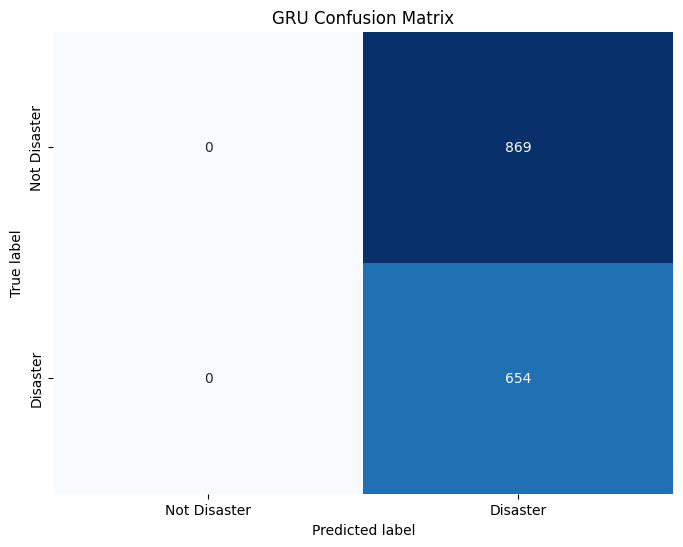

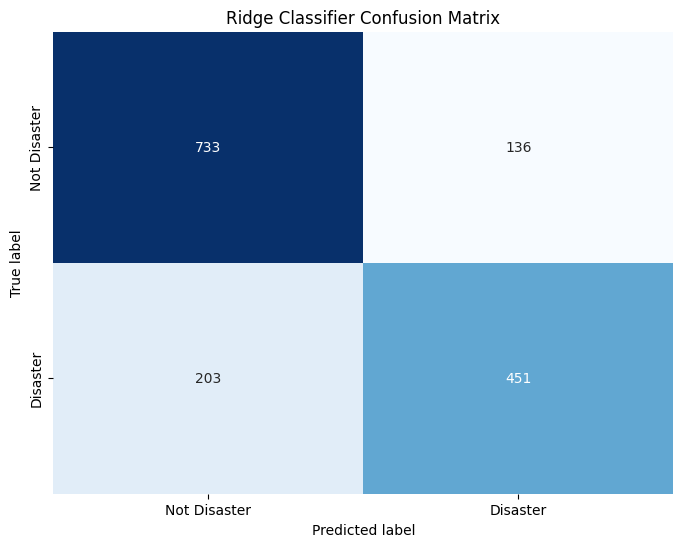

In [31]:
# Confusion matrix seaborn

from sklearn.metrics import confusion_matrix
import seaborn as sns   

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, lstm_preds), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
plt.title("LSTM Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, gru_preds), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
plt.title("GRU Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

lr_preds = clf.predict(val_vectors)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, lr_preds), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
plt.title("Ridge Classifier Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

### Kaggle Submission

In [27]:
test = pd.read_csv(f"{base_path}/test.csv")

test["clean_text"] = test["text"].apply(clean_text)

test_vectors = count_vectorizer.transform(test["clean_text"])

test_predictions = clf.predict(test_vectors)

test["target"] = test_predictions

test[["id", "target"]].to_csv(f"{base_path}/submission.csv", index=False)

### Final Conclusions

#### What didn't work:
LSTM and GRU: Probably because of an embeddings issue with my code, I tried multiple things like padding, balancing the classes, implementing Focal Loss and experimenting with the hyperparameters, but nothing seems to have worked.

#### What did work (although it's not great)
The ridge classifier using the base count_vectorizer produced an avg F1 score of 0.77, not great but definitely better than the 0 I got on the other models.

#### What I'd try next
I'll give the LSTM and GRU approaches another run and debug a bit. Tweaking the embeddings and doing a bit better in terms of preprocessing might help. But I also think that this could be a dataset size issue.


#### References
- Pytorch docs: https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- Kaggle tutorial on NLP: https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
- A couple of youtube videos on LSTM and GRU
- The Deep Learning Book: Ian Goodfellow, Yoshua Bengio, Aaron Courville